Evaluation of the Degree of Rate Control via Automatic Differentiation - supporting information
===============================================================================================



\author{Yilin Yang, Siddarth K. Achar and John R. Kitchin}

\maketitle

This supporting information contains the code to calculate the degree of the rate control for the three cases using the automatic differentiation. The code is in Julia.

Note DifferentialEquations requires sundials to be installed. On a Mac this can be installed with

brew install sundials
\#+END\_SRC

Each Case below should be run independently, e.g. if you use a Jupyter notebook you need to restart the kernel for each one.



## Case I



### Analytic solution



In this example we show that automatic differentiation is equivalent to an analytical derivative.



In [1]:
using GRUtils
using DifferentialEquations
using DiffEqSensitivity, ForwardDiff
using LaTeXStrings

We first define functions for the rate, and for the analytical derivatives that define each DRC.



In [2]:
function rate(k1, k2, aA, aB, t)
    theta_A = 1 / (1 + 1.0e5)
    return (k1 * aA) .* (1 .- exp.(-k2 * aB .* t)) .+ (k2 * aB * theta_A) .* exp.( -k2 .* aB .* t)
end

function drc1(k1, k2, aA, aB, t, rs)
    return (k1 ./ rs) .* aA .* (1 .- exp.(-k2 .* aB .* t))
end

function drc2(k1, k2, aA, aB, t, rs)
    theta_A = 1 / (1 + 1.0e5)
    term1 = (k1 * aA * aB) .* t .* exp.(-k2 .* aB .* t)
    term2 = (aB * theta_A) .* exp.(-k2 .* aB .* t)
    term3 = (k2 * aB^2 * theta_A) .* t .* exp.(-k2 .* aB .* t)
    return k2 ./ rs .* (term1 + term2 - term3)
end

drc2 (generic function with 1 method)

This simply evaluates the analytical derivative functions.



In [3]:
ts = LinRange(0, 4, 401)
k1 = 1.0e-5
k2 = 1.0
aA = 1.0
aB = 3.0
rs = rate(k1, k2, aA, aB, ts)
drc1_sol = drc1(k1, k2, aA, aB, ts, rs)
drc2_sol = drc2(k1, k2, aA, aB, ts, rs)

401-element Vector{Float64}:
  1.0
  0.970151497606985
  0.9406119414204311
  0.9113901749347935
  0.8824949171261274
  0.8539347450774003
  0.825718076597347
  0.7978531528975842
  0.7703480213941957
  0.7432105187010817
  0.7164482538830794
  0.6900685920371175
  0.6640786382695216
  ⋮
 -0.0001738281415268283
 -0.00016918844219553146
 -0.00016467115551404066
 -0.0001602730985310884
 -0.00015599116950702055
 -0.00015182234589398785
 -0.0001477636823645692
 -0.00014381230888773716
 -0.00013996542885108182
 -0.00013622031722824952
 -0.0001325743187905546
 -0.0001290248463617641

### Automatic Differentiation



To use automatic differentiation, we define the ODEs for the mole balances.



In [4]:
function state_eqn(dy, y, kf, t)
    aA = 1.0
    aB = 3.0
    kr1 = 0.0
    dy[1] = eq1 = kf[1] * aA * y[2] - kr1 * y[1] - kf[2] * aB * y[1]
    dy[2] = eq2 = -kf[1] * aA * y[2] + kr1 * y[1] + kf[2] * aB * y[1]
end

function calc_rate(y, kf)
    aB = 3.0
    rate = kf[2] * aB * y[1]
    return rate
end

calc_rate (generic function with 1 method)

Next, we integrate the ODEs to get the solution as a function of time.



In [5]:
tspan = (0., 4.)
theta_A = 1 / (1 + 1.0e5)
y0 = [theta_A, 1.0 - theta_A]
kf = [1.0e-5, 1.0]
prob = ODEProblem(state_eqn, y0, tspan, kf)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 4.0)
u0: 2-element Vector{Float64}:
 9.99990000099999e-6
 0.999990000099999

We define a wrapper function that we will take the derivative of.



In [6]:
function rate_wrapper(lnk)
    kf = exp.(lnk)
    nt = 401
    _prob = remake(prob, p=kf)  # must set "p=parameter" no matter the name of parameter

    theta_sol = Array(solve(_prob, RK4(), saveat=LinRange(0., 4., nt), sensealg=ForwardDiffSensitivity()))'  # [nt, nu]
    kf_matrix = reshape(kf, 1, size(kf, 1))
    kf_repeat = repeat(kf_matrix, nt, 1)
    r = Array{Real, 2}(undef, nt, 1)  # an vector with length of nt
    for i in 1:nt
        r[i, 1] = calc_rate(theta_sol[i, :], kf_repeat[i, :])
    end
    return log.(r)
end

rate_wrapper (generic function with 1 method)

Finally, we compute the derivative of the wrapper function with respect to $log(k_f)$.



In [7]:
ad_drcs = ForwardDiff.jacobian(rate_wrapper, log.(kf))

401×2 Matrix{Float64}:
 0.0        1.0
 0.0100502  0.970146
 0.0201983  0.940594
 0.03044    0.911362
 0.0407714  0.882463
 0.0511884  0.853909
 0.0616871  0.825711
 0.0722636  0.797877
 0.0829145  0.77041
 0.0936362  0.743313
 0.104426   0.716585
 0.115281   0.69022
 0.126197   0.664224
 ⋮          
 0.999059   0.00240508
 0.999067   0.00238952
 0.999077   0.00236915
 0.999088   0.00234382
 0.999101   0.00231336
 0.999114   0.00227764
 0.999129   0.0022365
 0.999145   0.00218979
 0.999163   0.00213736
 0.999182   0.00207907
 0.999203   0.00201475
 0.999226   0.00194426

This shows that the analytical DRC and AD DRCs are visibly indistinguishable.



In [8]:
fig = Figure((6, 4), "in")
plot(ts, drc1_sol,
     linewidth=6, xlabel="Time (s)", ylabel="Degree of Rate Control",
     label="DRC-1-Analytic", dpi=300, linecolor=0x187BCD)
hold(true)
plot(ts, drc2_sol, linewidth=6, label="DRC-2-Analytic", dpi=300, linecolor=0x4D4D4D)
plot(ts, ad_drcs[:, 1], linewidth=2, label="DRC-1-AD", dpi=300, linecolor=0xF16A70)
plot(ts, ad_drcs[:, 2], linewidth=2, label="DRC-2-AD", dpi=300, linecolor=0xB1D877)

legend(location=5)
savefig("si-2.png")

![img](./si-2.png "This is equivalent to figure 2 in the manuscript.")



## Case II



This is a more complex example with seven reactions.



In [9]:
using GRUtils
using DifferentialEquations
using DiffEqSensitivity, ForwardDiff
using LaTeXStrings

In [10]:
kf0 = Array([1.33e8, 2.01e11, 2.64e6, 5.24e1, 2.05e5, 1.48e12, 5.32e2])
K = Array([2.15e2, 5.93e-5, 6.28e-2, 1.18e-5, 1.03e3, 1.92e5, 4.50e1])

7-element Vector{Float64}:
    215.0
      5.93e-5
      0.0628
      1.18e-5
   1030.0
 192000.0
     45.0

In [11]:
function calc_rate2(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.07, 0.21, 0.085, 0.38])
    press = press .* 1.01325
    fwd_factor = Array([press[1] * y[1], press[2] * y[1], y[3] * y[1], y[5] *
        y[1], y[2] * y[6], y[7], y[4]^2])
    rev_factor = Array([y[2], y[3], y[4] * y[5], y[4] * y[6], y[7] * y[1],
                        press[3] * y[1], press[4] * y[1]^2])
    r = kf .* fwd_factor .- kr .* rev_factor
    return r
end

function calc_overall_rate2(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.07, 0.21, 0.085, 0.38])
    press = press .* 1.01325
    r1 = kf[7] * y[4]^2 - kr[7] * press[4] * y[1]^2
    return r1
end

function state_eqn2(y, kf, t)
    r = calc_rate2(y, kf)
    eq1 = -r[1] - r[2] -r[3] -r[4] + r[5] + r[6] + 2 * r[7] # *
    eq2 = r[1] - r[5] # CO*
    eq3 = r[2] - r[3] # H2O*
    eq4 = r[3] + r[4] - 2 * r[7] # H*
    eq5 = r[3] - r[4] # OH*
    eq6 = r[4] - r[5] # O*
    eq7 = r[5] - r[6] # CO2*
    Array([eq1, eq2, eq3, eq4, eq5, eq6, eq7])
end

state_eqn2 (generic function with 1 method)

In [12]:
tspan = (0., 50.)
y0 = [0.9; 0.01; 0.01; 0.01; 0.01; 0.01; 0.05]
prob2 = ODEProblem(state_eqn2, y0, tspan, kf0)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 50.0)
u0: 7-element Vector{Float64}:
 0.9
 0.01
 0.01
 0.01
 0.01
 0.01
 0.05

In [13]:
function rate_wrapper2(p)
    p = exp.(p)
    nt = 501
    _prob = remake(prob2, p=p)
    theta_sol = Array(solve(_prob, Kvaerno5(), saveat=LinRange(2.0, 50.0, nt),
                            sensealg=ForwardDiffSensitivity(), atol=1e-8, rtol=1e-8))' # [nt, nu]
    p_matrix = reshape(p, 1, size(p, 1)) # [1, np]
    p_repeat = repeat(p_matrix, nt, 1) # [nt, np]
    r = Array{Real, 1}(undef, nt)
    for i in 1:nt
        r[i] = calc_overall_rate2(theta_sol[i, :], p_repeat[i, :])
    end
    return log.(r)
end

rate_wrapper2 (generic function with 1 method)

In [14]:
drdp = ForwardDiff.jacobian(rate_wrapper2, log.(kf0))

501×7 Matrix{Float64}:
 -0.000135567  -3.87846e-12  -0.0039346    0.871996  0.109851  -6.23875e-11  -0.100164
 -0.000124538  -3.56207e-12  -0.00361353   0.872956  0.110363  -5.72342e-11  -0.0940927
 -9.62604e-5   -2.75081e-12  -0.00279034   0.875419  0.111673  -4.40216e-11  -0.0734419
 -5.89023e-5   -1.67903e-12  -0.0017028    0.878673  0.113404  -2.65662e-11  -0.044846
 -2.08788e-5   -5.88169e-13  -0.000595899  0.881985  0.115167  -8.7999e-12   -0.0151252
  9.01706e-6    2.69496e-13   0.000274401  0.884589  0.116552   5.16877e-12   0.00860227
  2.17123e-5    6.33651e-13   0.000643973  0.885695  0.117141   1.11006e-11   0.0189906
  1.01098e-5    3.00673e-13   0.000306209  0.884684  0.116603   5.67931e-12   0.0102476
 -5.92857e-6   -1.59557e-13  -0.000160685  0.883287  0.11586   -1.81454e-12  -0.00206998
 -1.90208e-5   -5.35239e-13  -0.000541815  0.882147  0.115253  -7.93183e-12  -0.0121397
 -2.94084e-5   -8.33302e-13  -0.000844208  0.881242  0.114771  -1.27854e-11  -0.0201459
 -3.73228

In [15]:
fig2 = Figure((6, 4), "in")
xs = ["1", "2", "3", "4", "5", "6", "7"]
barplot(xs, drdp[end, :], dpi=300)
ylim((0, 1))
ylabel("Degree of Rate Control")
xlabel("Step id")
savefig("si-3.png")

![img](./si-3.png "This is Figure 3 in the manuscript.")



## Case III



In [16]:
using GRUtils
using DifferentialEquations
using DiffEqSensitivity, ForwardDiff
using LaTeXStrings

In [17]:
# Pre-calculated from the energies
kf0 = Array([1.87e8, 1.87e8, 1.87e8, 1.8883185167968056e9, 1.322049155405556e7,
             9.606108656999557e9, 1.0790409835530733e10, 3.930665236502143e7,
             2.3091859525960427e7, 561418.3516964992, 218543.129742791,
             9.818482331329404e11, 8480.066664476652, 2106.812489014142,
             1.0e13, 1.0e13, 0.19579578392147623])

K = Array([0.3200776001873334, 10.40372197634553, 13.121524676913081,
           2.732767674835581e10, 90853.07029698449, 1.8828894331792707e6,
           1.492835002616191e9, 5.543477568325298e11, 350.58978957927326, 40.07010486794337,
           0.0007668179990975123, 6060.791562549015, 5.333375260677139e-5,
           1.3250393012667561e-5, 2.592779654046556e14, 7.83206922497337e11, 9.149335697265244e-10])

17-element Vector{Float64}:
     0.3200776001873334
    10.40372197634553
    13.121524676913081
     2.732767674835581e10
 90853.07029698449
     1.8828894331792707e6
     1.492835002616191e9
     5.543477568325298e11
   350.58978957927326
    40.07010486794337
     0.0007668179990975123
  6060.791562549015
     5.333375260677139e-5
     1.3250393012667561e-5
     2.592779654046556e14
     7.83206922497337e11
     9.149335697265244e-10

In [18]:
function calc_rate(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.1, 0.0, 0.0, 0.0, 0.05])
    fwd_factor = Array([press[1] * y[1], press[1] * y[1], press[1] * y[1], y[2]* y[5],
                        y[3] * y[5], y[4] * y[5], y[6] * y[5], y[10] * y[7], y[8], y[9], y[12],
                        y[11], y[13], y[14], y[16] * y[15], y[17] * y[17], y[16]])
    rev_factor = Array([y[2], y[3], y[4], y[6] * y[7], y[8], y[9], y[10] * y[1],
                        y[11] * y[12], y[13] * y[1], y[14] * y[1], press[3] * y[15], press[2] * y[15],
                        press[4] * y[15], press[4] * y[15], y[5] * y[17], y[16] * y[1], press[5] * y[1]])
    r = kf .* fwd_factor .- kr .* rev_factor
    return r
end

function calc_overall_rate(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.1, 0.0, 0.0, 0.0, 0.05])
    r1 = y[13] * kf[13]
    r2 = y[14] * kf[14]
    r = r1 + r2
    return r
end

function state_eqn(dy, y, kf, t)
    r = calc_rate(y, kf)
    dy[1] = -r[1] - r[2] - r[3] + r[7] + r[9] + r[10] + r[16] + r[17] # *
    dy[2] = r[1] - r[4] # C3H6-1*
    dy[3] = r[2] - r[5] # C3H6-2*
    dy[4] = r[3] - r[6] # C3H6-3*
    dy[5] = -r[4] - r[5] - r[6] - r[7] + r[15] # O*
    dy[6] = r[4] - r[7] # C3H5*
    dy[7] = r[4] - r[8] # OH*
    dy[8] = r[5] - r[9] # OMP-1*
    dy[9] = r[6] - r[10] # OMP-2*
    dy[10] = r[7] - r[8] # C3H5O*
    dy[11] = r[8] - r[12] # C3H4O*
    dy[12] = r[8] - r[11] # H2O*
    dy[13] = r[9] - r[13] # PO-1*
    dy[14] = r[10] - r[14] # PO-2*
    dy[15] = r[11] + r[12] + r[13] + r[14] - r[15] # v*
    dy[16] = -r[15] + r[16] - r[17] # O2*
    dy[17] = r[15] - 2 * r[16] # O-1*
end

state_eqn (generic function with 1 method)

In [19]:
tspan = (0., 1.)
y0 = [0.68; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02;
      0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02]
prob = ODEProblem(state_eqn, y0, tspan, kf0)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: 17-element Vector{Float64}:
 0.68
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02

In [20]:
function rate_wrapper(p)
    p = exp.(p)
    nt = 201
    _prob = remake(prob, p=p)
    theta_sol = Array(solve(_prob, Rodas4P(), saveat=LinRange(0., 0.02, 201),
                            sensealg=ForwardDiffSensitivity(), atol=1e-8, rtol=1e-8))' # [nt, nu]
    p_matrix = reshape(p, 1, size(p, 1)) # [1, np]
    p_repeat = repeat(p_matrix, nt, 1) # [nt, np]
    r = Array{Real, 1}(undef, nt)
    for i in 1:nt
        r[i] = calc_overall_rate(theta_sol[i, :], p_repeat[i, :])
    end
    return log.(r) # here, we take care with the second reaction
end

rate_wrapper (generic function with 1 method)

In [21]:
drdp = ForwardDiff.jacobian(rate_wrapper, log.(kf0))

201×17 Matrix{Float64}:
 0.0          0.0          0.0        0.0         …  0.199002  0.0           0.0          0.0
 0.000140291  0.000235166  0.0870994  0.00472637     0.661352  8.9376e-8    -1.69054e-6  -0.113988
 0.000722106  0.000190174  0.198013   0.0161561      0.801318  6.18345e-8   -1.77174e-6  -0.249245
 0.00158909   0.000207795  0.292634   0.0291107      0.879454  4.70839e-8   -1.66016e-6  -0.366824
 0.00257824   0.000252158  0.370735   0.0417718      0.919055  3.64719e-8   -1.42016e-6  -0.463347
 0.00359386   0.000306132  0.432572   0.0533075   …  0.939302  2.83264e-8   -1.15698e-6  -0.541995
 0.00458931   0.000360327  0.483395   0.0637586      0.95062   2.19809e-8   -9.18453e-7  -0.606769
 0.00550682   0.00040903   0.522706   0.0726784      0.95782   1.69207e-8   -7.13638e-7  -0.661423
 0.00635016   0.000452459  0.555768   0.0805647      0.962591  1.31928e-8   -5.55975e-7  -0.705199
 0.00713804   0.000491964  0.584273   0.0876893      0.966452  1.03671e-8   -4.35099e-7  -

In [22]:
fig = Figure()
xs = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17"]
barplot(xs, drdp[end, :], dpi=300)
ylabel("Degree of Rate Control")
xlabel("Step id")
savefig("si-4.png")

![img](./si-4.png "This corresponds to Figure 4.")



In [23]:
fig = Figure()
plot(LinRange(0.0, 0.02, 201), drdp, linewidth=3,
     xlabel="Time (s)",
     ylabel="Degree of Rate Control (s)", dpi=300)

legend("DRC1", "DRC2", "DRC3", "DRC4", "DRC5", "DRC6", "DRC7", "DRC8", "DRC9",
       "DRC10", "DRC11", "DRC12", "DRC13", "DRC14", "DRC15", "DRC16", "DRC17",
       location=12)

savefig("si-4a.png")

![img](./si-4a.png "Time dependent DRC for each reaction (not shown in the manuscript).")



## Figure 5



In [24]:
import Pkg; Pkg.add("BenchmarkTools")

In [25]:
using GRUtils
using DifferentialEquations
using DiffEqSensitivity, ForwardDiff
using LaTeXStrings
using BenchmarkTools

In [26]:
Eaf = Array([0.00, 0.00, 0.00, 0.36, 0.59, 0.31, 0.30, 0.54,
             0.62, 0.77, 0.76, 0.10, 0.90, 0.96, 0.00, 0.00, 1.36])
Ear = Array([0.42, 0.57, 0.58, 1.40, 1.10, 0.95, 1.19, 1.72, 0.83,
             0.89, 0.00, 0.00, 0.00, 0.00, 1.43, 1.18, 0.00])
Af = Array([1.87e8, 1.87e8, 1.87e8, 8.03e12, 1.17e13, 1.28e13,
            1.14e13, 1.09e13, 4.10e13, 3.24e13, 1.00e13,
            1.00e13, 1.00e13, 1.00e13, 1.00e13, 1.00e13, 1.00e13])
Ar = Array([1.00e13, 1.00e13, 1.00e13, 8.93e12, 1.78e13, 1.92e13,
            7.14e12, 1.54e13, 1.53e13, 1.31e13, 2.85e8, 1.62e8,
            1.59e8, 1.59e8, 1.00e13, 1.00e13, 2.14e8])

# reaction conditions
# p_C3H6 = 0.1  # 0.01 - 0.5 bar
# p_O2 = 0.05  # 0.01 - 0.5 bar, https://doi.org/10.1016/j.jcat.2010.09.002
T= 350
times = 15.0  # end time for simulation
np = 1501  # number of points
kb = 8.617333262145e-5
kf0 = Af .* exp.(-Eaf ./ (T * kb))
kr0 = Ar .* exp.(-Ear ./ (T * kb))
K = kf0 ./ kr0

17-element Vector{Float64}:
   20.872546100528705
 3016.3405010833485
 4202.173967255303
    8.495813690618929e14
    1.4502492307661682e7
    1.0952244663399394e9
    1.0438608184641424e13
    6.9367803791872456e16
 2831.1269056019605
  132.18971425689134
    3.9961041134068033e-7
 2241.5496407486125
    6.905152211410761e-9
    9.445202678799137e-10
    3.900261523392704e20
    9.800588792613136e16
    1.2202480858241735e-15

In [27]:
function calc_rate(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.1, 0.0, 0.0, 0.0, 0.05])
    fwd_factor = Array([press[1] * y[1], press[1] * y[1], press[1] * y[1], y[2] * y[5],
                        y[3] * y[5], y[4] * y[5], y[6] * y[5],
                        y[10] * y[7], y[8], y[9], y[12], y[11], y[13], y[14], y[16] * y[15],
                        y[17] * y[17], y[16]])
    rev_factor = Array([y[2], y[3], y[4], y[6] * y[7], y[8], y[9], y[10] * y[1], y[11] * y[12],
                        y[13] * y[1], y[14] * y[1],
                        press[3] * y[15], press[2] * y[15], press[4] * y[15], press[4] * y[15],
                        y[5] * y[17], y[16] * y[1], press[5] * y[1]])
    r = kf .* fwd_factor .- kr .* rev_factor
    return r
end

calc_rate (generic function with 1 method)

In [28]:
function calc_overall_rate(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.1, 0.0, 0.0, 0.0, 0.05])
    r1 = y[13] * kf[13]
    r2 = y[14] * kf[14]
    r = r1 + r2
    return r
end

calc_overall_rate (generic function with 1 method)

In [29]:
function state_eqn(dy, y, kf, t)
    r = calc_rate(y, kf)    
    dy[1] = -r[1] - r[2] - r[3] + r[7] + r[9] + r[10] + r[16] + r[17]  # *
    dy[2] = r[1] - r[4]  # C3H6-1*
    dy[3] = r[2] - r[5]  # C3H6-2*
    dy[4] = r[3] - r[6]   # C3H6-3*
    dy[5] = -r[4] - r[5] - r[6] - r[7] + r[15]  # O*
    dy[6] =  r[4] - r[7] # C3H5*
    dy[7] =  r[4] - r[8] # OH*
    dy[8] =  r[5] - r[9] # OMP-1*
    dy[9] =  r[6] - r[10] # OMP-2*
    dy[10] = r[7] - r[8]  # C3H5O*
    dy[11] = r[8] - r[12]  # C3H4O*
    dy[12] = r[8] - r[11]  # H2O*
    dy[13] = r[9] - r[13]  # PO-1*
    dy[14] = r[10] - r[14]  # PO-2*
    dy[15] = r[11] + r[12] + r[13] + r[14] - r[15]  # v*
    dy[16] = -r[15] + r[16] - r[17]  # O2*
    dy[17] =  r[15] - 2 * r[16] # O-1*
end

state_eqn (generic function with 1 method)

In [30]:
tspan = (0., times + 1.0)
y0 = [0.68; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02;
      0.02; 0.02; 0.02; 0.02; 0.02; 0.02]
prob = ODEProblem(state_eqn, y0, tspan, kf0);

In [31]:
function rate_wrapper(p)
    p = exp.(p)
    nt = np
    _prob = remake(prob, p=p)
    theta_sol = Array(solve(_prob, Rodas4P(), saveat=LinRange(0., times, np), 
                sensealg=ForwardDiffSensitivity(), atol=1e-8, rtol=1e-8))'  # [nt, nu]
    p_matrix = reshape(p, 1, size(p, 1))  # [1, np]
    p_repeat = repeat(p_matrix, nt, 1)  # [nt, np]
    r = Array{Real, 1}(undef, nt)
    for i in 1:nt
        r[i] = calc_overall_rate(theta_sol[i, :], p_repeat[i, :])
    end
    return log.(r)  # here, we take care with the second reaction
end

rate_wrapper (generic function with 1 method)

Here we measure how long it takes to compute the derivatives. We do this twice. The first time includes compiling time. The second time does not include that.



In [32]:
@time drdp = ForwardDiff.jacobian(rate_wrapper, log.(kf0))
@time drdp = ForwardDiff.jacobian(rate_wrapper, log.(kf0))

 12.804368 seconds (11.74 M allocations: 900.148 MiB, 1.44% gc time, 99.32% compilation time)
  0.076779 seconds (281.96 k allocations: 147.359 MiB, 24.85% gc time)


1501×17 Matrix{Float64}:
  0.0          0.0         0.0           0.0          …   0.0           0.0           0.0
 -0.00399755   9.61583e-5  0.0042394    -0.00542944       7.89408e-8    6.61814e-9   -0.000584464
 -0.00154971   8.31498e-5  0.00167367   -0.00213341       5.16514e-8    4.60157e-9   -0.000261893
 -0.000524881  6.43145e-5  0.000701612  -0.000732041      1.81218e-8    1.13217e-10  -0.000424031
 -0.000158407  5.66038e-5  0.00048945   -0.000225451      5.53392e-9   -2.89243e-9   -0.000688568
 -3.91155e-5   5.38658e-5  0.000678655  -5.78401e-5   …   9.50733e-10  -5.3132e-9    -0.00111
  5.09909e-6   5.26928e-5  0.00108609    6.36799e-6      -6.34863e-10  -6.93231e-9   -0.00168479
  1.86994e-5   5.21626e-5  0.00164997    2.88169e-5      -1.17293e-9   -7.61491e-9   -0.00236869
  2.31524e-5   5.18243e-5  0.00230405    3.94447e-5      -1.32559e-9   -7.69637e-9   -0.00313166
  2.39026e-5   5.15637e-5  0.00302769    4.59905e-5      -1.34847e-9   -7.53107e-9   -0.00395582
  2.3196e-5

In [33]:
fig1 = Figure()
plot(LinRange(0., times, np), drdp, linewidth=3, xlabel = "Time (s)",
     ylabel = "Degree of Rate Control (s)", 
     title = "Degree of Rate Control", dpi=300)
legend("DRC1", "DRC2", "DRC3", "DRC4", "DRC5", "DRC6", "DRC7", "DRC8", "DRC9", "DRC10", 
       "DRC11", "DRC12", "DRC13", "DRC14", "DRC15", "DRC16", "DRC17", location=12)
savefig("si-5a.png")

![img](./si-5a.png)

Finite difference approach.



In [36]:
function trans_finite_forward(old_k, pert, prob, idx_k)
    new_k_1 = deepcopy(old_k)
    new_k_2 = deepcopy(old_k)
    new_k_1[idx_k] = old_k[idx_k] * (1 - pert)
    new_k_2[idx_k] = old_k[idx_k] * (1 + pert)
    _prob_1 = remake(prob, p=new_k_1)
    new_ode_sol_1 = solve(_prob_1, Rodas4P(), saveat=LinRange(0., times, np), atol=1e-8, rtol=1e-8)
    new_coverage_1 = Array(new_ode_sol_1)  # [nc, nt]
    new_rates_1 = Array{Float64, 1}(undef, size(new_coverage_1, 2))
    for it in 1:size(new_coverage_1, 2)
        new_rates_1[it] = calc_overall_rate(new_coverage_1[:, it], new_k_1)
    end

    _prob_2 = remake(prob, p=new_k_2)
    new_ode_sol_2 = solve(_prob_2, Rodas4P(), saveat=LinRange(0., times, np), atol=1e-8, rtol=1e-8)
    new_coverage_2 = Array(new_ode_sol_2)  # [nc, nt]
    new_rates_2 = Array{Float64, 1}(undef, size(new_coverage_2, 2))
    for it in 1:size(new_coverage_2, 2)
        new_rates_2[it] = calc_overall_rate(new_coverage_2[:, it], new_k_2)
    end

    delta_ln_rate = log.(new_rates_2) .- log.(new_rates_1)
    delta_ln_k = log.(new_k_2[idx_k]) - log.(new_k_1[idx_k])
    drc = delta_ln_rate ./ delta_ln_k
    return drc
end

trans_finite_forward (generic function with 1 method)

In [35]:
trans_cands = 10 .^(LinRange(-1., -14., 14))

fd_trans_drcs = Array{Float64, 3}(undef, size(trans_cands, 1), size(kf0, 1), np)

for (idx, c) in enumerate(trans_cands)
    @time begin
        for idx_k in 1:size(kf0, 1)
            fd_trans_drcs[idx, idx_k, :] = trans_finite_forward(kf0, c, prob, idx_k)
        end
    end
end

 37.146138 seconds (79.35 M allocations: 5.922 GiB, 4.06% gc time)
  0.456742 seconds (4.84 M allocations: 361.671 MiB, 15.97% gc time)
  0.450571 seconds (4.84 M allocations: 361.671 MiB, 15.85% gc time)
  0.486266 seconds (4.84 M allocations: 361.671 MiB, 21.70% gc time)
  0.448078 seconds (4.84 M allocations: 361.671 MiB, 15.39% gc time)
  0.454482 seconds (4.84 M allocations: 361.671 MiB, 16.41% gc time)
  0.449408 seconds (4.84 M allocations: 361.671 MiB, 16.06% gc time)
  0.494170 seconds (4.84 M allocations: 361.671 MiB, 21.68% gc time)
  0.450478 seconds (4.84 M allocations: 361.671 MiB, 15.83% gc time)
  0.454372 seconds (4.84 M allocations: 361.671 MiB, 15.43% gc time)
  0.456002 seconds (4.84 M allocations: 361.671 MiB, 15.77% gc time)
  0.505248 seconds (4.84 M allocations: 361.671 MiB, 21.59% gc time)
  0.447975 seconds (4.84 M allocations: 361.671 MiB, 15.26% gc time)
  0.450191 seconds (4.84 M allocations: 361.671 MiB, 15.74% gc time)


In [37]:
fig2 = Figure()

lw = 1.5
sub1 = subplot(2, 2, 1)
target_k = 3
# plot(LinRange(0., 0.02, 201), drdp[:, target_k], linewidth=3, linecolor=0x7F58AF, dpi=300, alpha=0.7)
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-3", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-3", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-3", dpi=300, linecolor=0xFEB326)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)

sub2 = subplot(2, 2, 2)
target_k = 4
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-4", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-4", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-4", dpi=300, linecolor=0xFEB326)
hold(true)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)

sub3 = subplot(2, 2, 3)
target_k = 14
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-14", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-14", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-14", dpi=300, linecolor=0xFEB326)
hold(true)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)

sub4 = subplot(2, 2, 4)
target_k = 17
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-17", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-17", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)",
     ylabel = "DRC-17", dpi=300, linecolor=0xFEB326)
hold(true)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)


savefig("si-5.png")

![img](./si-5.png "This is figure 5 in the manuscript.")



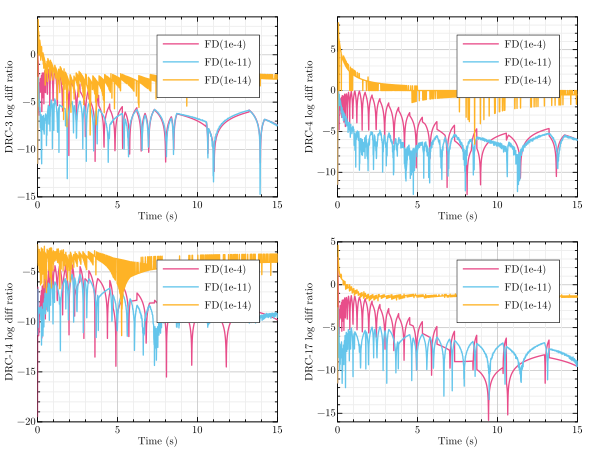

DRC 3 average different percentage: 1.0%, 0.0%, 21.0%
DRC 4 average different percentage: 7.0%, 1.0%, 778.0%
DRC 14 average different percentage: 0.0%, 0.0%, 2.0%
DRC 17 average different percentage: 4.0%, 0.0, 54.0


In [38]:
fig3 = Figure()

lw = 1.5
sub1 = subplot(2, 2, 1)
target_k = 3

percent_diff = abs.(fd_trans_drcs[:, target_k, :] .- transpose(repeat(drdp[:, target_k], 1, 14)) 
                    .+ 1e-15) ./ abs.(transpose(repeat(drdp[:, target_k], 1, 14)) .+ 1e-10)
plot(LinRange(0., times, np), log.(percent_diff[4, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-3 log diff ratio", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[11, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-3 log diff ratio", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[14, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-3 log diff ratio", dpi=300, linecolor=0xFEB326)
legend("FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=1)

pct_diff_4 = round(mean(percent_diff[4, :]) * 100)
pct_diff_11 = round(mean(percent_diff[11, :]) * 100)
pct_diff_14 = round(mean(percent_diff[14, :]) * 100)
println("DRC 3 average different percentage: $pct_diff_4%, $pct_diff_11%, $pct_diff_14%")

sub2 = subplot(2, 2, 2)
target_k = 4

percent_diff = abs.(fd_trans_drcs[:, target_k, :] .- transpose(repeat(drdp[:, target_k], 1, 14)) 
                    .+ 1e-15) ./ abs.(transpose(repeat(drdp[:, target_k], 1, 14)) .+ 1e-10)
plot(LinRange(0., times, np), log.(percent_diff[4, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-4 log diff ratio", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[11, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-4 log diff ratio", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[14, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-4 log diff ratio", dpi=300, linecolor=0xFEB326)
legend("FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=1)

pct_diff_4 = round(mean(percent_diff[4, :]) * 100)
pct_diff_11 = round(mean(percent_diff[11, :]) * 100)
pct_diff_14 = round(mean(percent_diff[14, :]) * 100)
println("DRC 4 average different percentage: $pct_diff_4%, $pct_diff_11%, $pct_diff_14%")

sub3 = subplot(2, 2, 3)
target_k = 14

percent_diff = abs.(fd_trans_drcs[:, target_k, :] .- transpose(repeat(drdp[:, target_k], 1, 14)) 
                    .+ 1e-15) ./ abs.(transpose(repeat(drdp[:, target_k], 1, 14)) .+ 1e-10)
plot(LinRange(0., times, np), log.(percent_diff[4, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-14 log diff ratio", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[11, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-14 log diff ratio", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[14, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-14 log diff ratio", dpi=300, linecolor=0xFEB326)
legend("FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=1)

pct_diff_4 = round(mean(percent_diff[4, :]) * 100)
pct_diff_11 = round(mean(percent_diff[11, :]) * 100)
pct_diff_14 = round(mean(percent_diff[14, :]) * 100)
println("DRC 14 average different percentage: $pct_diff_4%, $pct_diff_11%, $pct_diff_14%")

sub4 = subplot(2, 2, 4)
target_k = 17

percent_diff = abs.(fd_trans_drcs[:, target_k, :] .- transpose(repeat(drdp[:, target_k], 1, 14)) 
                    .+ 1e-15) ./ abs.(transpose(repeat(drdp[:, target_k], 1, 14)) .+ 1e-10)
plot(LinRange(0., times, np), log.(percent_diff[4, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-17 log diff ratio", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[11, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-17 log diff ratio", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), log.(percent_diff[14, :]), linewidth=lw, xlabel = "Time (s)", 
     ylabel = "DRC-17 log diff ratio", dpi=300, linecolor=0xFEB326)
legend("FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=1)

pct_diff_4 = round(mean(percent_diff[4, :]) * 100)
pct_diff_11 = round(mean(percent_diff[11, :]) * 100)
pct_diff_14 = round(mean(percent_diff[14, :]) * 100)
println("DRC 17 average different percentage: $pct_diff_4%, $pct_diff_11, $pct_diff_14")

display(fig3)

savefig("si-6.png")

### An alternative way to calculate the Transient DRC



The transient DRC shown in the manuscript corresponds to the case that we perturb the kinetic rates at zero time, then let the concentrations to reach to a quasi-steady state, then calculate the DRC. However, Campbell suggests that to apply DRC in transient kinetics, we need to firstly simulate the reactions using the original kinetic parameters from time $0$ to a time of interest $t$, then perturb the kinetic parameters and let the concentrations to reach to a quasi-steady state and calculate the DRC [campbell-2001-findin-rate](campbell-2001-findin-rate). Here, we implemented this idea using the code below. It turns out that the DRCs are the same across the time range. This is because in this implementation, the only difference at each timestamp is to treat the state at time $t$ as the new initial state to simulate the reactions, which does not change the quasi-steady state, which in turn makes the DRC the same for all these timestamps.



In [39]:
ode_sol = solve(prob, Rodas4P(), saveat=LinRange(0., times, np))
ode_sol = Array(ode_sol)'  # get the state at step i by ode_sol[i, :]

1501×17 adjoint(::Matrix{Float64}) with eltype Float64:
 0.68        0.02        0.02        0.02        …  0.02      0.02         0.02      0.02
 2.7075e-7   5.64955e-7  8.18627e-5  7.4547e-5      0.111268  2.13827e-13  0.825693  2.96719e-7
 7.15398e-8  1.49251e-7  2.1619e-5   1.65554e-5     0.131999  7.26307e-14  0.835958  1.74201e-7
 2.46066e-8  5.13277e-8  7.43379e-6  4.9698e-6      0.138158  2.90819e-14  0.838554  1.09941e-7
 9.89765e-9  2.06395e-8  2.98896e-6  1.61104e-6     0.14044   1.44151e-14  0.839397  7.76665e-8
 5.32049e-9  1.10889e-8  1.60592e-6  6.48039e-7  …  0.141377  9.76824e-15  0.839671  6.39783e-8
 3.73618e-9  7.78114e-9  1.12717e-6  3.35226e-7     0.141878  8.19017e-15  0.83977   5.86369e-8
 3.19126e-9  6.64081e-9  9.62475e-7  2.21814e-7     0.142215  7.66932e-15  0.839803  5.67463e-8
 2.98191e-9  6.19999e-9  8.9916e-7   1.68006e-7     0.1425    7.46629e-15  0.839814  5.5992e-8
 2.90223e-9  6.02949e-9  8.75021e-7  1.38612e-7     0.14277   7.37519e-15  0.839817  5.

In [41]:
drdp_outer = Array{Float64, 2}(undef, np, 17)

for i in 1:np
    prob = ODEProblem(state_eqn, ode_sol[i, :], tspan, kf0)
    drdp = ForwardDiff.jacobian(rate_wrapper, log.(kf0))
    drdp_outer[i, :] = drdp[20, :]
end

In [1]:
fig4 = Figure()
plot(LinRange(0., times, np), drdp_outer, linewidth=3, xlabel = "Time (s)", 
     ylabel = "Degree of Rate Control (s)", title = "Degree of Rate Control", dpi=300)
legend("DRC1", "DRC2", "DRC3", "DRC4", "DRC5", "DRC6", "DRC7", "DRC8", "DRC9", "DRC10", 
       "DRC11", "DRC12", "DRC13", "DRC14", "DRC15", "DRC16", "DRC17", location=12)
display(fig4)
savefig("si-7.png")
close('all')

# [goto error]
syntax: character literal contains multiple characters

Stacktrace:
 [1] top-level scope
   @ In[16]:8
 [2] eval
   @ ./boot.jl:360 [inlined]
 [3] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
   @ Base ./loading.jl:1094

![img](./si-7.png "Campbell's transient DRCs for case III (not shown in the manuscript).")



## DELSA for Uncertain Parameters



Please find the related code at our [GitHub repo](https://github.com/yilinyang1/autodiff-drc).

To generate the figures run these commands with that code:

    julia run_drc.jl PO-input.yaml --output_path PO-output
    julia run_drc.jl PO-input-delsa.yaml --output_path PO-output-delsa --delsa

After that, this code (in Python) was used for Figure 6 in manuscript.

    from matplotlib import pyplot as plt
    import numpy as np
    
    data = np.load("./autodiff-drc/PO-output-delsa/delsa-sensit.npy")
    
    def subplot(fig, ax_index, param_index, data, title):
        ax = fig.add_subplot(1, 3, ax_index)
        ax.hist(data[:, -1, param_index], bins=15, color=[(252/255, 78/255, 3/255)], rwidth=0.9)
        ax.set_xlim([0, 1])
        ax.set_xlabel("Delsa Importance Measure")
        ax.set_ylabel("Frequency")
        ax.set_title(title)
        ax.grid()
        ax.text(0.35, 31, f"Mean: {round(data[:, -1, param_index].mean(), 3)}", fontsize=13)
        return ax
    
    
    fig = plt.figure(figsize=(16, 5))
    subplot(fig, 1, 2, data, r"DELSA-$k_{3}$")
    subplot(fig, 2, 13, data, r"DELSA-$k_{14}$")
    subplot(fig, 3, 16, data, r"DELSA-$k_{17}$");
    fig.savefig('./si-8.png')

![img](./.ob-jupyter/ff2adeb6f417625c28b435c12f3b744eca565d9e.png)

![img](./si-8.png "This is Figure 6 in manuscript.")

\newpage


[../bibliography/references.bib](../bibliography/references.bib)

